## Multiple Linear Regression

Multiple linear regression attempts to model the relationship between two or more explanatory variables and a response variable by fitting a linear equation to observed data. Every value of the independent variable x is associated with a value of the dependent variable y.`

In this exercise, a linear regression model on U.S. crime data will be built and tested. Specifically, the model will be trained on New York (NY) 2013 data, and tested on Alabama (AL) 2013 and NY 2014. The datasets were taken from https://ucr.fbi.gov/crime-in-the-u.s.

NY 2013:<br> 
https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls

AL 2013:<br> 
https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_alabama_by_city_2013.xls

NY 2014:<br> 
https://ucr.fbi.gov/crime-in-the-u.s/2014/crime-in-the-u.s.-2014/tables/table-8/table-8-by-state/Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014.xls

### A. Data Exploration and Cleaning

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import linear_model
%matplotlib inline

In [2]:
# Open the NY 2013 dataset (skip first four rows).
df_ny13 = pd.read_csv('https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv', skiprows=4)
df_ny13.shape

(351, 13)

In [3]:
# View the first five rows.
df_ny13.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,"1,861",0,0.0,NaN,0,0,0,12,2,10,0,0.0
1,Addison Town and Village,"2,577",3,0.0,NaN,0,0,3,24,3,20,1,0.0
2,Akron Village,"2,846",3,0.0,NaN,0,0,3,16,1,15,0,0.0
3,Albany,"97,956",791,8.0,NaN,30,227,526,"4,090",705,"3,243",142,NaN
4,Albion Village,"6,388",23,0.0,NaN,3,4,16,223,53,165,5,NaN


In [4]:
# Check variable types.
df_ny13.dtypes

City                                       object
Population                                 object
Violent\ncrime                             object
Murder and\nnonnegligent\nmanslaughter    float64
Rape\n(revised\ndefinition)1              float64
Rape\n(legacy\ndefinition)2                object
Robbery                                    object
Aggravated\nassault                        object
Property\ncrime                            object
Burglary                                   object
Larceny-\ntheft                            object
Motor\nvehicle\ntheft                      object
Arson3                                    float64
dtype: object

In [5]:
# Rename columns.
df_ny13.rename(columns={'City': 'city','Population': 'population', 'Violent\ncrime': 'violent_crime', 'Murder and\nnonnegligent\nmanslaughter': 'murder', 'Rape\n(legacy\ndefinition)2': 'rape','Robbery': 'robbery', 'Aggravated\nassault': 'aggravated_assault', 'Property\ncrime': 'property_crime', 'Burglary': 'burglary', 'Larceny-\ntheft': 'larceny_theft', 'Motor\nvehicle\ntheft': 'motor_vehicle_theft', 'Arson3': 'arson'}, inplace=True)

# Show null count for each column.
df_ny13.isnull().sum()

city                              0
population                        3
violent_crime                     3
murder                            3
Rape\n(revised\ndefinition)1    351
rape                              3
robbery                           3
aggravated_assault                3
property_crime                    3
burglary                          3
larceny_theft                     3
motor_vehicle_theft               3
arson                           164
dtype: int64

In [6]:
# Check null rows.
df_ny13.tail()

,city,population,violent_crime,murder,Rape (revised definition)1,rape,robbery,aggravated_assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson
346,Yonkers,"199,134","1,036",6.0,NaN,25,390,615,"2,368",470,"1,662",236,10.0
347,Yorktown Town,"36,643",15,0.0,NaN,0,2,13,334,45,287,2,NaN
348,1 The figures shown in this column for the off...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
349,2 The figures shown in this column for the off...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
350,3 The FBI does not publish arson data unless i...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Drop unnecessary variables.
df_ny13_final = df_ny13.drop(['city', 'Rape\n(revised\ndefinition)1'], axis=1)

# Drop last three rows with nulls.
df_ny13_final = df_ny13_final[:-3]

# Convert arson nulls to 0.
df_ny13_final['arson'] = df_ny13_final['arson'].fillna(0)

# Create function to remove commas and convert object type columns to numeric.
cols_ny13 = df_ny13_final.columns[df_ny13_final.dtypes.eq('object')]
convert_col = lambda col_obj: pd.to_numeric(col_obj.replace(',',''))
df_ny13_final[cols_ny13] = df_ny13_final[cols_ny13].applymap(convert_col)

### B. Build the Model

Feature selection is the process of automatically selecting those features in the data that contribute most to the prediction variable or output of interest. Feature selection is particularly important because irrelevant features in the data can decrease the accuracy of many models, especially linear algorithms like linear and logistic regression.

A number of feature selection techniques exist. For demonstration purposes, two techniques will be utilized and compared with feature engineering to select the variables and set the regression coefficients.

#### 1. Feature Selection

##### a. Univariate Selection
The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features.

In [8]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

y_ny13 = df_ny13_final['property_crime']
X_ny13 = df_ny13_final.drop('property_crime', axis=1)
skb_ny13 = SelectKBest(score_func=chi2, k=4)
fit_ny13 = skb_ny13.fit(X_ny13, y_ny13)
np.set_printoptions(precision=3)
print(fit_ny13.scores_)

[  1.755e+09   1.364e+07   7.423e+04   2.160e+05   5.060e+06   8.330e+06
   2.480e+06   2.194e+07   1.573e+06   2.143e+04]


The following features have the highest scores and will be selected to build the model:

population = 1.755e+09<br>
violent_crime = 1.364e+07<br>
aggravated_assault = 8.330e+06<br>
larceny_theft = 2.194e+07<br>

In [9]:
# Create the model with the selected features.
import statsmodels.formula.api as smf
rc_ny13_pval = smf.ols(formula='property_crime ~ population + violent_crime + aggravated_assault + larceny_theft', data=df_ny13_final).fit()

# Print the summary table.
rc_ny13_pval.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         property_crime   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.504e+05
Date:                Mon, 15 Jan 2018   Prob (F-statistic):               0.00
Time:                        17:36:22   Log-Likelihood:                -1985.2
No. Observations:                 348   AIC:                             3980.
Df Residuals:                     343   BIC:                             4000.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             30.8124      4.717      6.532      0.000      21.534      40.090
population            -0.0050      0.000    -18.592      0.000      -0.006      -0.004
violent_crime          3.2517      0.185     17.578      0.000       2.888       3.616
aggravated_assault    -4.6277      0.325    -14.255      0.000      -5.266      -3.989
larceny_theft          1.3614      0.014     94.982      0.000       1.333       1.390
==============================================================================
Omnibus:                      343.551   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13771.495
Skew:                           4.102   Prob(JB):                         0.00
Kurtosis:                      32.706   Cond. No.                     5.43e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.43e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### b. Feature Importance

Bagged decision trees like Random Forest and Extra Trees can be used to estimate the importance of features. Construct a ExtraTreesClassifier classifier for this example.

In [10]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()
etc.fit(X_ny13, y_ny13)
print(etc.feature_importances_)

[ 0.167  0.1    0.016  0.06   0.073  0.097  0.142  0.197  0.106  0.042]


The following features have the highest scores and will be selected to build the model: population, violent_crime, burglary, larceny_theft. The results are similar to univariate selection except for one feature.

In [11]:
# Create the model on the selected features.
rc_ny13_pvbl = smf.ols(formula='property_crime ~ population + violent_crime + burglary + larceny_theft', data=df_ny13_final).fit()

# Print the summary table.
rc_ny13_pvbl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         property_crime   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.704e+07
Date:                Mon, 15 Jan 2018   Prob (F-statistic):               0.00
Time:                        17:36:22   Log-Likelihood:                -1306.3
No. Observations:                 348   AIC:                             2623.
Df Residuals:                     343   BIC:                             2642.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.2855      0.710     -1.812      0.071      -2.681       0.110
population        0.0002   5.54e-05      3.758      0.000    9.93e-05       0.000
violent_crime     0.1005      0.006     15.647      0.000       0.088       0.113
burglary          1.2100      0.007    163.368      0.000       1.195       1.225
larceny_theft     0.9740      0.003    280.824      0.000       0.967       0.981
==============================================================================
Omnibus:                       90.276   Durbin-Watson:                   2.134
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2296.037
Skew:                          -0.363   Prob(JB):                         0.00
Kurtosis:                      15.563   Cond. No.                     5.74e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.74e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 2. Feature Engineering

There's practically no limit to the techniques that can be utilized in feature engineering. Anything that transforms potential predictor variables into features that make them best-suited to work within the model to explain variance in the outcome of interest can be tried and tested. In this example, the effect of population will be enhanced by creating a population squared feature. In addition, since all the independent variables are continuous, the effect of categorical variables will be incorporated by creating and including them in the model; in this case, from murder and robbery.

In [12]:
# Create features. Non-zero values of murder and robbery will be coded as 1. 
df_ny13_final['population_squared'] = df_ny13_final['population'] * df_ny13_final['population']
df_ny13_final['murder_category'] = np.where(df_ny13_final['murder']>0, 1, 0)
df_ny13_final['robbery_category'] = np.where(df_ny13_final['robbery']>0, 1, 0)

# Create the model based on these features.
rc_ny13_ppmr = smf.ols(formula='property_crime ~ population + population_squared + murder_category + robbery_category', data=df_ny13_final).fit()

# Print the summary table.
rc_ny13_ppmr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         property_crime   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 2.204e+04
Date:                Mon, 15 Jan 2018   Prob (F-statistic):               0.00
Time:                        17:36:22   Log-Likelihood:                -2639.5
No. Observations:                 348   AIC:                             5289.
Df Residuals:                     343   BIC:                             5308.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -109.5753     40.989     -2.673      0.008    -190.197     -28.954
population             0.0347      0.001     29.955      0.000       0.032       0.037
population_squared -2.111e-09   1.37e-10    -15.390      0.000   -2.38e-09   -1.84e-09
murder_category       15.1867     87.625      0.173      0.863    -157.163     187.536
robbery_category     -96.2774     56.836     -1.694      0.091    -208.068      15.513
==============================================================================
Omnibus:                      129.816   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18476.109
Skew:                          -0.223   Prob(JB):                         0.00
Kurtosis:                      38.693   Cond. No.                     1.30e+13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.3e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### C. Linear Regression Assumptions

The three models exhibit possible overfitting since each R-squared value, which is a measure the model's accuracy, is exactly or close to 1.0. Overfitting can be caused by a failure in one or more of the four linear regression assumptions:

1. Linear relationship - If the relationship is non-linear, the regression model will try to find any hint of a linear relationship, and only explain that – with predictable consequences for the validity of the model.

2. Multivariate normality - The error from the model (calculated by subtracting the model-predicted values from the real outcome values) should be normally distributed. Since ordinary least squares regression models are fitted by choosing the parameters that best minimize error, skewness or outliers in the error can result in serious miss-estimations.

3. Homoscedasticity - The distribution of the error terms (its "scedasticity"), should be consistent for all predicted values, or homoscedastic. For example, if the error terms aren't consistently distributed and there are more variance in the error for large outcome values than for small ones, the confidence interval for large predicted values will be too small because it will be based on the average error variance. This leads to overconfidence in the accuracy of the model's predictions.

4. Low multicollinearity - Correlations among features should be low or nonexistent. When features are correlated, they may both explain the same pattern of variance in the outcome. The model will attempt to find a solution, potentially by attributing half the explanatory power to one feature and half to the other. 

The models will be tested on multivariate normality and homoscedasticity as these explain overfitting the most.

#### 1. Multivariate Normality

##### a. Feature Engineering-Derived Model

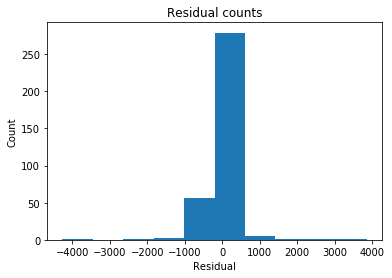

In [13]:
# Extract the appopriate variables.
y_ny13_ppmr = df_ny13_final['property_crime']
X_ny13_ppmr = df_ny13_final[['population','population_squared','murder_category','robbery_category']]

# Fit the model.
regr_ny13_ppmr = linear_model.LinearRegression()
regr_ny13_ppmr.fit(X_ny13_ppmr, y_ny13_ppmr)

# Plot the residuals, or difference between actual and predicted values.
predicted_ny13_ppmr = regr_ny13_ppmr.predict(X_ny13_ppmr)
actual_ny13_ppmr = y_ny13_ppmr
residual_ny13_ppmr = actual_ny13_ppmr - predicted_ny13_ppmr
plt.hist(residual_ny13_ppmr)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

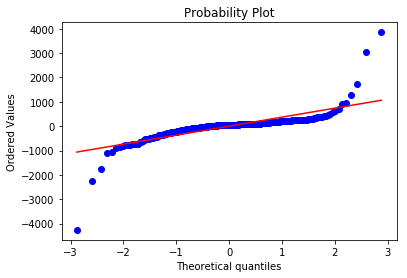

In [14]:
# Confirm with QQ plot.
import pylab 
import scipy.stats as stats

stats.probplot(residual_ny13_ppmr, plot=pylab)
plt.show()

The outliers shown in the residual plot and the curved QQ plot confirm that the residuals are not normally distributed. These are most likely caused by outliers in the data, and can be fixed with non-linear transformations in either dependent or independent variables, or both.

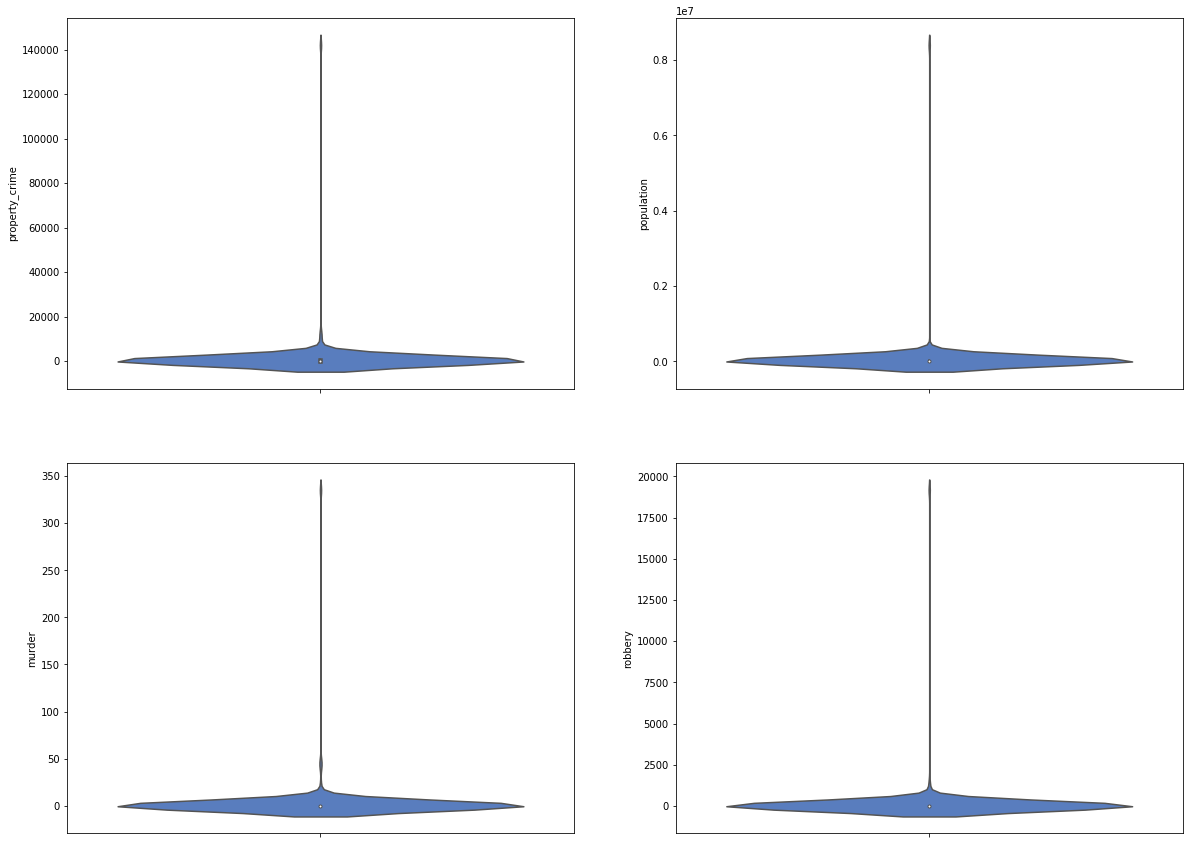

In [15]:
# Check for outliers in the dependent and principal independent variables.
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

sns.violinplot(y='property_crime', palette='muted', data=df_ny13_final, ax=ax1)
sns.violinplot(y='population', palette='muted', data=df_ny13_final, ax=ax2)
sns.violinplot(y='murder', palette='muted', data=df_ny13_final, ax=ax3)
sns.violinplot(y='robbery', palette='muted', data=df_ny13_final, ax=ax4)
plt.show()

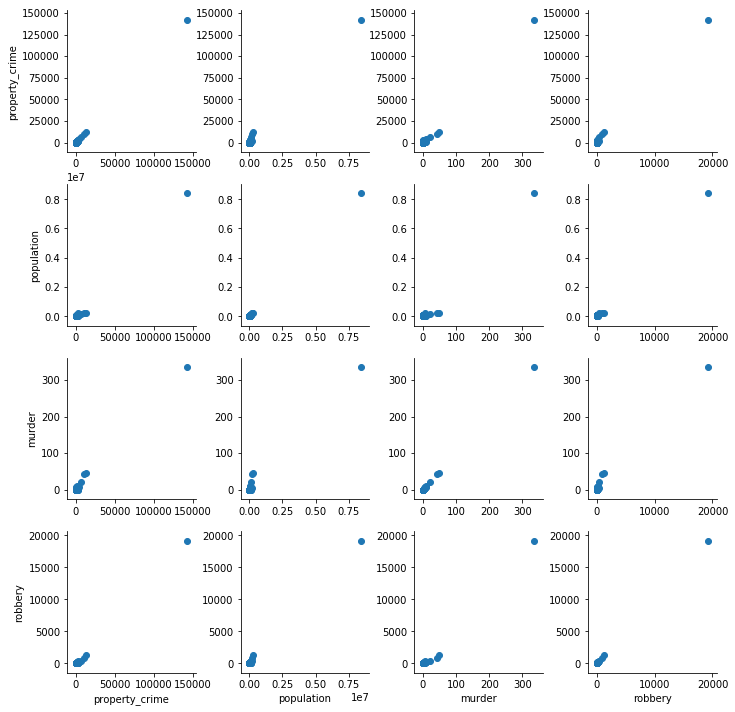

In [16]:
# Verify with a pair plot.
g = sns.PairGrid(df_ny13_final[['property_crime', 'population', 'murder', 'robbery']])
g = g.map(plt.scatter)

In [17]:
# Show outliers.
print(df_ny13_final['property_crime'].sort_values(ascending=False).head(10))
print('\n')
print(df_ny13_final['population'].sort_values(ascending=False).head(10))
print('\n')
print(df_ny13_final['murder'].sort_values(ascending=False).head(10))
print('\n')
print(df_ny13_final['robbery'].sort_values(ascending=False).head(10))

216    141971
35      12491
272     10051
310      6473
3        4090
218      2807
285      2800
53       2689
321      2528
346      2368
Name: property_crime, dtype: int64


216    8396126
35      258789
272     210562
346     199134
310     143834
7       118296
3        97956
126      96667
267      87204
57       80705
Name: population, dtype: int64


216    335.0
35      47.0
272     42.0
310     21.0
140     10.0
3        8.0
285      8.0
321      7.0
262      7.0
346      6.0
Name: murder, dtype: float64


216    19170
35      1322
272      918
310      400
346      390
206      228
3        227
140      204
285      203
218      166
Name: robbery, dtype: int64


In [18]:
# Transformation causes error. Check for zeroes in property_crime (dependent variable).
df_ny13_final[df_ny13_final['property_crime'] == 0]

,population,violent_crime,murder,rape,robbery,aggravated_assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson,population_squared,murder_category,robbery_category
186,1688,0,0.0,0,0,0,0,0,0,0,0.0,2849344,0,0
208,1622,0,0.0,0,0,0,0,0,0,0,0.0,2630884,0,0
256,1274,0,0.0,0,0,0,0,0,0,0,0.0,1623076,0,0
287,872,0,0.0,0,0,0,0,0,0,0,0.0,760384,0,0
295,1437,0,0.0,0,0,0,0,0,0,0,0.0,2064969,0,0
319,615,0,0.0,0,0,0,0,0,0,0,0.0,378225,0,0


In [19]:
# Drop rows with zeroes.
df_ny13_final_nzpc = df_ny13_final[df_ny13_final['property_crime'] != 0]

Removing rows with zeroes in the dependent variable should not adversely impact the model since they don't add to the model's predictive value. The same can't be said for independent variables. Rows with zero independent variables will not be dropped, therefore, transformation will be limited to the dependent variable. Log transformation will be conducted since it is best suited for dealing with outliers, which causes residual non-normality.

In [20]:
# Run the model with log transformation on the dependent variable.
# Set the appropriate variables.
y_ny13_ppmr_nzpc = np.log(df_ny13_final_nzpc['property_crime'])
X_ny13_ppmr_nzpc = df_ny13_final_nzpc[['population','population_squared','murder_category','robbery_category']]

# Fit the model.
regr_ny13_ppmr_nzpc = linear_model.LinearRegression()
regr_ny13_ppmr_nzpc.fit(X_ny13_ppmr_nzpc, y_ny13_ppmr_nzpc)

print('\nCoefficients: \n', regr_ny13_ppmr_nzpc.coef_)
print('\nIntercept: \n', regr_ny13_ppmr_nzpc.intercept_)
print('\nR-squared:')
print(regr_ny13_ppmr_nzpc.score(X_ny13_ppmr_nzpc, y_ny13_ppmr_nzpc))


Coefficients: 
 [  2.533e-05  -2.926e-12   4.946e-01   1.631e+00]

Intercept: 
 3.29309526531

R-squared:
0.690682085308


R-squared dropped from 0.996 to 0.691.

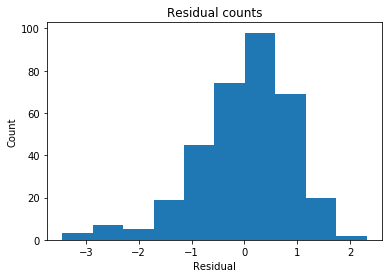

In [21]:
# Verify residual distribution.
predicted_ny13_ppmr_nzpc = regr_ny13_ppmr_nzpc.predict(X_ny13_ppmr_nzpc)
actual_ny13_ppmr_nzpc = y_ny13_ppmr_nzpc
residual_ny13_ppmr_nzpc = actual_ny13_ppmr_nzpc - predicted_ny13_ppmr_nzpc
plt.hist(residual_ny13_ppmr_nzpc)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

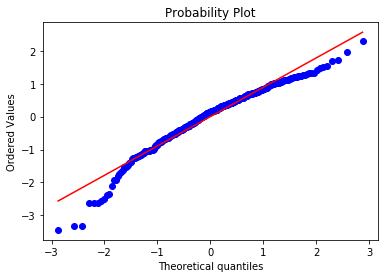

In [22]:
# Check with QQ plot.
stats.probplot(residual_ny13_ppmr_nzpc, plot=pylab)
plt.show()

Both plots improved, which confirms the log transform's effect on the dependent variable. Check if R-squared can be improved by removing outliers in the log-transformed data.

In [23]:
# Drop the rows containing the population outliers.
df_ny13_or = df_ny13_final_nzpc[df_ny13_final_nzpc['population']<100000]

# Set the variables.
y_ny13_ppmr_orlt = np.log(df_ny13_or['property_crime'])
X_ny13_ppmr_orlt = df_ny13_or[['population','population_squared','murder_category','robbery_category']]

# Fit the model.
regr_ny13_ppmr_orlt = linear_model.LinearRegression()
regr_ny13_ppmr_orlt.fit(X_ny13_ppmr_orlt, y_ny13_ppmr_orlt)

print('\nCoefficients: \n', regr_ny13_ppmr_orlt.coef_)
print('\nIntercept: \n', regr_ny13_ppmr_orlt.intercept_)
print('\nR-squared:')
print(regr_ny13_ppmr_orlt.score(X_ny13_ppmr_orlt, y_ny13_ppmr_orlt))


Coefficients: 
 [  9.633e-05  -6.955e-10   1.421e-01   1.165e+00]

Intercept: 
 2.9921533517

R-squared:
0.732091721047


R-squared improved from 0.691 to 0.732. Optimum outlier removal appears to be at population over 100,000.

In [24]:
# Verify with an OLS regression table.
rc_ny13_ppmr_orlt = smf.ols(formula='np.log(property_crime) ~ population + population_squared + murder_category + robbery_category', data=df_ny13_or).fit()

# Print the summary table.
rc_ny13_ppmr_orlt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     np.log(property_crime)   R-squared:                       0.732
Model:                                OLS   Adj. R-squared:                  0.729
Method:                     Least Squares   F-statistic:                     226.1
Date:                    Mon, 15 Jan 2018   Prob (F-statistic):           2.62e-93
Time:                            17:36:28   Log-Likelihood:                -396.86
No. Observations:                     336   AIC:                             803.7
Df Residuals:                         331   BIC:                             822.8
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.9922      0.076     39.116      0.000       2.842       3.143
population          9.633e-05   7.99e-06     12.060      0.000    8.06e-05       0.000
population_squared -6.955e-10   9.89e-11     -7.031      0.000    -8.9e-10   -5.01e-10
murder_category        0.1421      0.149      0.951      0.342      -0.152       0.436
robbery_category       1.1651      0.105     11.066      0.000       0.958       1.372
==============================================================================
Omnibus:                       58.340   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.501
Skew:                          -0.934   Prob(JB):                     3.72e-25
Kurtosis:                       5.131   Cond. No.                     4.53e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.53e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

After a log transform, only the murder_category feature has an insignificant p value (> 0.05), and can be discarded from the model. The rest are significant (< 0.05), which means the null hypothesis that they don't have an effect on the dependent variable can be rejected; as such, they can be kept in the model.

In [25]:
# Check the new parameters.
rc_ny13_ppr_orlt = smf.ols(formula='np.log(property_crime) ~ population + population_squared + robbery_category', data=df_ny13_or).fit()

# Print the summary table.
rc_ny13_ppr_orlt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     np.log(property_crime)   R-squared:                       0.731
Model:                                OLS   Adj. R-squared:                  0.729
Method:                     Least Squares   F-statistic:                     301.3
Date:                    Mon, 15 Jan 2018   Prob (F-statistic):           2.18e-94
Time:                            17:36:28   Log-Likelihood:                -397.32
No. Observations:                     336   AIC:                             802.6
Df Residuals:                         332   BIC:                             817.9
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.9834      0.076     39.292      0.000       2.834       3.133
population          9.855e-05   7.64e-06     12.900      0.000    8.35e-05       0.000
population_squared -7.096e-10   9.78e-11     -7.257      0.000   -9.02e-10   -5.17e-10
robbery_category       1.1703      0.105     11.132      0.000       0.964       1.377
==============================================================================
Omnibus:                       57.965   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.749
Skew:                          -0.933   Prob(JB):                     8.94e-25
Kurtosis:                       5.105   Cond. No.                     3.37e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.37e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

There was an insignificant decrease in R-squared after removing murder_category. The final Feature Engineering-derived model will therefore consist of the remaining three features.

##### b. Feature Selection-Derived Models

In [26]:
# Conduct log transformation on the Univariate Selection model.
# Set the variables.
y_ny13_pval_orlt = y_ny13_ppmr_orlt
X_ny13_pval_orlt = df_ny13_or[['population', 'violent_crime', 'aggravated_assault', 'larceny_theft']]

# Fit the model.
regr_ny13_pval_orlt = linear_model.LinearRegression()
regr_ny13_pval_orlt.fit(X_ny13_pval_orlt, y_ny13_pval_orlt)

print('\nCoefficients: \n', regr_ny13_pval_orlt.coef_)
print('\nIntercept: \n', regr_ny13_pval_orlt.intercept_)
print('\nR-squared:')
print(regr_ny13_pval_orlt.score(X_ny13_pval_orlt, y_ny13_pval_orlt))


Coefficients: 
 [  3.089e-05   4.366e-03  -1.119e-02   2.111e-03]

Intercept: 
 3.8548861166

R-squared:
0.569651626528


In [27]:
# Conduct log transformation on the Feature Importance model.
# Set the variables.
y_ny13_pvbl_orlt = y_ny13_ppmr_orlt
X_ny13_pvbl_orlt = df_ny13_or[['population', 'violent_crime', 'burglary', 'larceny_theft']]

# Fit the model.
regr_ny13_pvbl_orlt = linear_model.LinearRegression()
regr_ny13_pvbl_orlt.fit(X_ny13_pvbl_orlt, y_ny13_pvbl_orlt)

print('\nCoefficients: \n', regr_ny13_pvbl_orlt.coef_)
print('\nIntercept: \n', regr_ny13_pvbl_orlt.intercept_)
print('\nR-squared:')
print(regr_ny13_pvbl_orlt.score(X_ny13_pvbl_orlt, y_ny13_pvbl_orlt))


Coefficients: 
 [  3.541e-05  -4.756e-03   3.793e-03   1.488e-03]

Intercept: 
 3.82165769733

R-squared:
0.573887514317


The Feature Engineering-derived model's R-squared is higher than both the Feature Selection models after a log transform on the outlier-removed data; therefore, the Feature Engineering-derived model will be selected and used for training and testing.

#### 2. Homoscedasticity

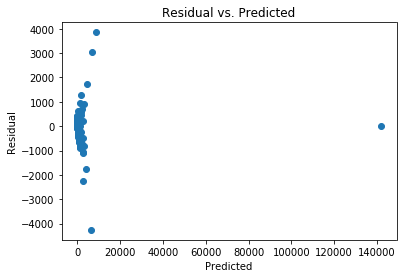

In [28]:
# Check for heteroscedasticity.
# Set the variables.
y_ny13_ppr = y_ny13_ppmr
X_ny13_ppr = df_ny13_final[['population','population_squared', 'robbery_category']]

# Fit the model.
regr_ny13_ppr = linear_model.LinearRegression()
regr_ny13_ppr.fit(X_ny13_ppr, y_ny13_ppr)

# Plot the predicted vs. the residual values.
predicted_ny13_ppr = regr_ny13_ppr.predict(X_ny13_ppr)
actual_ny13_ppr = y_ny13_ppr
residual_ny13_ppr = actual_ny13_ppr - predicted_ny13_ppr
plt.scatter(predicted_ny13_ppmr, residual_ny13_ppmr)
plt.title('Residual vs. Predicted')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.show()

Variable transformation can also address heteroscedasticity issues. The following plots show the corresponding effects.

##### a. Log-Transformed with Outliers

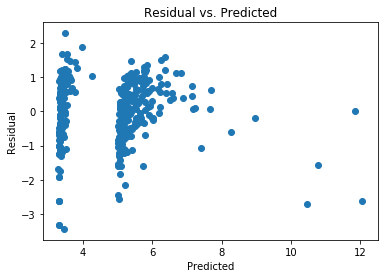

In [29]:
# Set the variables.
y_ny13_ppr_nzpc = y_ny13_ppmr_nzpc
X_ny13_ppr_nzpc = df_ny13_final_nzpc[['population','population_squared','robbery_category']]

# Fit the model.
regr_ny13_ppr_nzpc = linear_model.LinearRegression()
regr_ny13_ppr_nzpc.fit(X_ny13_ppr_nzpc, y_ny13_ppr_nzpc)

# Plot predicted vs. residual values.
predicted_ny13_ppr_nzpc = regr_ny13_ppr_nzpc.predict(X_ny13_ppr_nzpc)
actual_ny13_ppr_nzpc = y_ny13_ppr_nzpc
residual_ny13_ppr_nzpc = actual_ny13_ppr_nzpc - predicted_ny13_ppr_nzpc
plt.scatter(predicted_ny13_ppr_nzpc, residual_ny13_ppr_nzpc)
plt.title('Residual vs. Predicted')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.show()

##### b. Outliers Removed, No Transformation

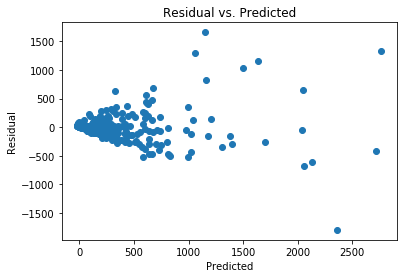

In [30]:
# Set the variables.
y_ny13_ppr_or = df_ny13_or['property_crime']
X_ny13_ppr_or = df_ny13_or[['population','population_squared', 'robbery_category']]

# Fit the model.
regr_ny13_ppr_or = linear_model.LinearRegression()
regr_ny13_ppr_or.fit(X_ny13_ppr_or, y_ny13_ppr_or)

# Plot predicted vs. residual values.
predicted_ny13_ppr_or = regr_ny13_ppr_or.predict(X_ny13_ppr_or)
actual_ny13_ppr_or = y_ny13_ppr_or
residual_ny13_ppr_or = actual_ny13_ppr_or - predicted_ny13_ppr_or
plt.scatter(predicted_ny13_ppr_or, residual_ny13_ppr_or)
plt.title('Residual vs. Predicted')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.show()

##### c. Log-Transformed, Outliers Removed

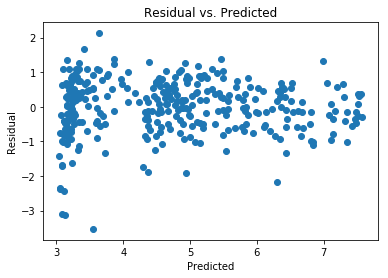

In [31]:
# Set the variables.
y_ny13_ppr_orlt = y_ny13_ppmr_orlt
X_ny13_ppr_orlt = X_ny13_ppr_or

# Fit the model.
regr_ny13_ppr_orlt = linear_model.LinearRegression()
regr_ny13_ppr_orlt.fit(X_ny13_ppr_orlt, y_ny13_ppr_orlt)

# Plot predicted vs. residual values.
predicted_ny13_ppr_orlt = regr_ny13_ppr_orlt.predict(X_ny13_ppr_orlt)
actual_ny13_ppr_orlt = y_ny13_ppr_orlt
residual_ny13_ppr_orlt = actual_ny13_ppr_orlt - predicted_ny13_ppr_orlt
plt.scatter(predicted_ny13_ppr_orlt, residual_ny13_ppr_orlt)
plt.title('Residual vs. Predicted')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.show()

As with multivariate non-normality, log transformation on the dependent variable where the outliers have been removed appear to have the most effect on heteroscedasticity.

### D. Train and Test the Model

#### 1. Train the Current Dataset

The current dataset, NY 2013, will be trained and tested using two methods - train/test split and K-folds cross validation.

##### a. Train/Test Split

In [32]:
# Split the data into train and test samples. Use the outlier-removed, log-transformed dataset.
from sklearn.model_selection import train_test_split
X_train_tts_ny13, X_test_tts_ny13, y_train_tts_ny13, y_test_tts_ny13 = train_test_split(X_ny13_ppr_orlt, y_ny13_ppr_orlt, test_size=0.3)

# Train the model.
regr_tts_ny13 = linear_model.LinearRegression()
lm_tts_ny13 = regr_tts_ny13.fit(X_train_tts_ny13, y_train_tts_ny13)

# Make predictions on the test sample.
predictions_tts_ny13 = regr_tts_ny13.predict(X_test_tts_ny13)

# Compare predicted vs. actual.
print('Predicted:', predictions_tts_ny13[0:5])
print('\n')
print('Actual:')
print(y_test_tts_ny13[0:5])

Predicted: [ 4.535  6.47   4.694  5.38   5.045]


Actual:
144    3.637586
257    6.349139
329    5.267858
115    5.837730
181    4.110874
Name: property_crime, dtype: float64


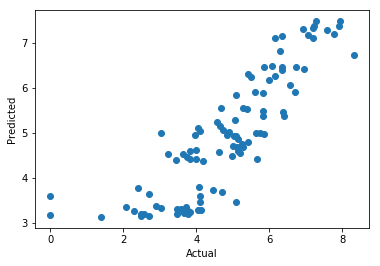

In [33]:
# Show scatterplot of predicted vs. actual.
plt.scatter(y_test_tts_ny13, predictions_tts_ny13)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [34]:
# Model score.
print('Score:', lm_tts_ny13.score(X_test_tts_ny13, y_test_tts_ny13))

Score: 0.73050872704


##### b. K-Folds Cross Validation

In [35]:
# Run the default three subsets, or folds, for cross validation.
from sklearn.cross_validation import cross_val_score, cross_val_predict
scores_cv_ny13 = cross_val_score(lm_tts_ny13, X_ny13_ppmr_orlt, y_ny13_ppmr_orlt)

# The score for each fold.
print('Cross validated scores:', scores_cv_ny13)

# Mean score.
print('Average score:', scores_cv_ny13.mean())

Cross validated scores: [ 0.712  0.702  0.708]
Average score: 0.707356052874


C:\Users\James\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


The cross validation average score - equivalent to the R-squared, or model accuracy - is slightly lower than the train/test split score.

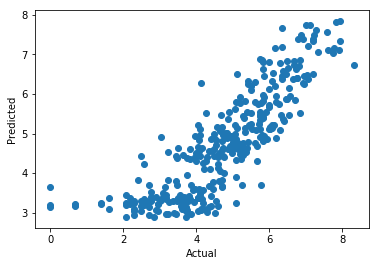

In [36]:
# Show scatterplot of predicted vs. actual.
predictions_cv_ny13 = cross_val_predict(lm_tts_ny13, X_ny13_ppmr_orlt, y_ny13_ppmr_orlt)
plt.scatter(y_ny13_ppmr_orlt, predictions_cv_ny13)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

There are three times as many datapoints as train/test split since testing is performed over three folds.

#### 2. Test on New Datasets

The model will be tested on different datasets, one will be the same state but different year, while the other will be a different state in the same year. The datasets will be transformed so they have similar features as the NY 2013 training data. Note that when the new datasets (i.e., tests) are not similar to the training data, the model returns erroneous results.

##### a. Same State, Different Year

In [37]:
# Open the NY 2014 data.
df_ny14 = pd.read_excel('Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014.xls', skiprows=4)
df_ny14.dtypes

City                                       object
Population                                float64
Violent\ncrime                            float64
Murder and\nnonnegligent\nmanslaughter    float64
Rape\n(revised\ndefinition)1              float64
Rape\n(legacy\ndefinition)2               float64
Robbery                                   float64
Aggravated\nassault                       float64
Property\ncrime                           float64
Burglary                                  float64
Larceny-\ntheft                           float64
Motor\nvehicle\ntheft                     float64
Arson3                                    float64
dtype: object

In [38]:
# Rename applicable columns.
df_ny14.rename(columns={'Population': 'population', 'Robbery': 'robbery', 'Property\ncrime': 'property_crime'}, inplace=True)
df_ny14_ppr = df_ny14[['population', 'robbery', 'property_crime']]

# Show null count.
df_ny14_ppr.isnull().sum()

population        7
robbery           7
property_crime    8
dtype: int64

In [39]:
# Check the null rows.
df_ny14_ppr[df_ny14_ppr.isnull().any(axis=1)]

,population,robbery,property_crime
364,10739.0,1.0,NaN
369,NaN,NaN,NaN
370,NaN,NaN,NaN
371,NaN,NaN,NaN
372,NaN,NaN,NaN
373,NaN,NaN,NaN
374,NaN,NaN,NaN
375,NaN,NaN,NaN


In [40]:
# Remove rows with nulls to prevent errors with log transformation.
df_ny14_ppr = df_ny14_ppr.dropna()

# Check for zeroes in property_crime.
df_ny14_ppr[df_ny14_ppr['property_crime'] == 0]

,population,robbery,property_crime
10,2250.0,0.0,0.0
169,1178.0,0.0,0.0
238,1084.0,0.0,0.0
301,857.0,0.0,0.0
308,1429.0,0.0,0.0
335,612.0,0.0,0.0


In [41]:
# Remove rows with zeroes in property_crime to prevent errors with log transformation.
df_ny14_ppr_nzpc = df_ny14_ppr[df_ny14_ppr['property_crime'] != 0]

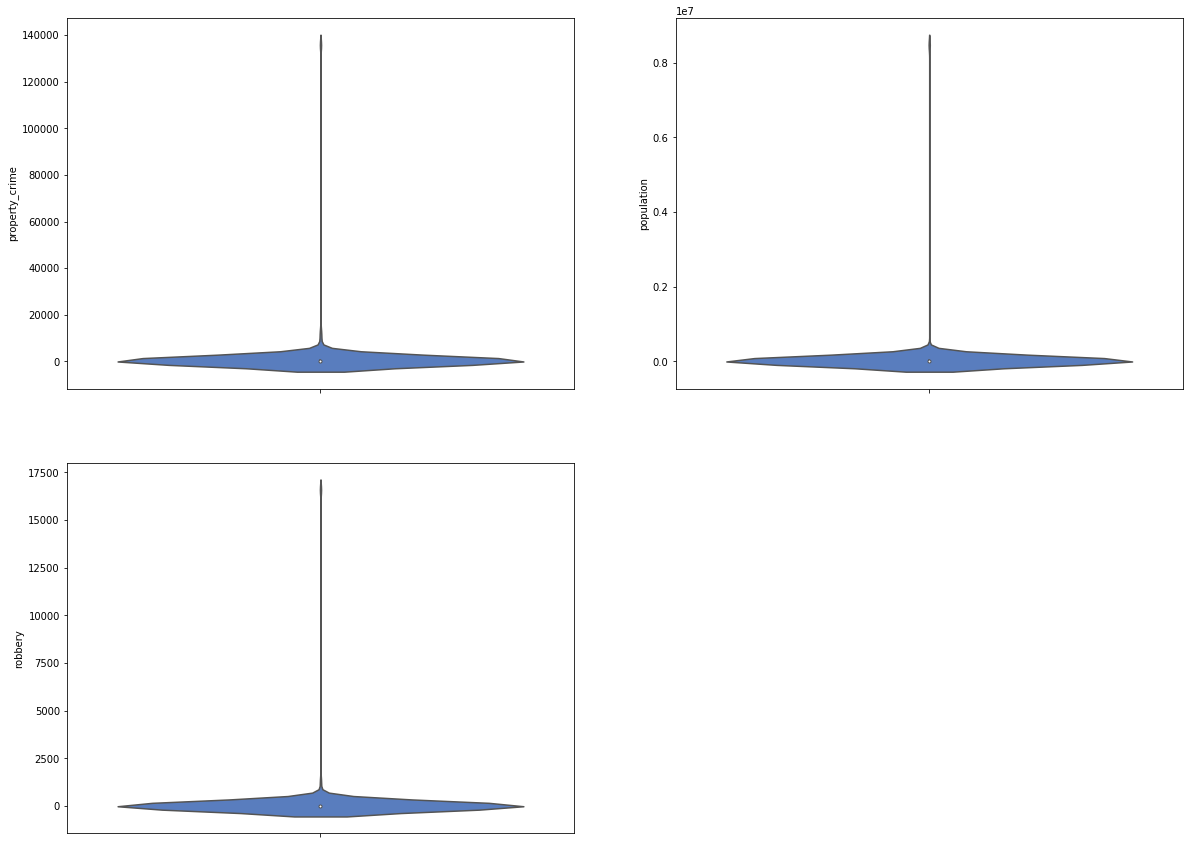

In [42]:
# Check for outliers.
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)

sns.violinplot(y='property_crime', palette='muted', data=df_ny14_ppr_nzpc, ax=ax1)
sns.violinplot(y='population', palette='muted', data=df_ny14_ppr_nzpc, ax=ax2)
sns.violinplot(y='robbery', palette='muted', data=df_ny14_ppr_nzpc, ax=ax3)
plt.show()

In [43]:
# Show top outliers.
print(df_ny14_ppr_nzpc['property_crime'].sort_values(ascending=False).head(10))
print('\n')
print(df_ny14_ppr_nzpc['population'].sort_values(ascending=False).head(10))
print('\n')
print(df_ny14_ppr_nzpc['robbery'].sort_values(ascending=False).head(10))

227    135747.0
38      12449.0
283      8856.0
326      5755.0
4        3888.0
57       2699.0
229      2641.0
299      2518.0
130      2430.0
338      2366.0
Name: property_crime, dtype: float64


227    8473938.0
38      258419.0
283     210347.0
366     200624.0
326     144534.0
9       118860.0
4        98595.0
130      97144.0
279      88881.0
62       81435.0
Name: population, dtype: float64


227    16581.0
38      1277.0
283      698.0
326      406.0
366      358.0
147      248.0
4        237.0
218      195.0
229      161.0
299      158.0
Name: robbery, dtype: float64


In [44]:
# Remove outliers.
df_ny14_ppr_or = df_ny14_ppr_nzpc[df_ny14_ppr_nzpc['population']<100000]

# Create the same features as NY 2013 and create the NY 2014 dataframe based on these features.
df_ny14_ppr_or['population_squared'] = df_ny14_ppr_or['population'] * df_ny14_ppr_or['population']
df_ny14_ppr_or['robbery_category'] = np.where(df_ny14_ppr_or['robbery']>0, 1, 0)

# Set the variables.
y_ny14_ppr_orlt = np.log(df_ny14_ppr_or.loc[:,'property_crime'])
X_ny14_ppr_orlt = df_ny14_ppr_or.loc[:, ['population','population_squared', 'robbery_category']]

C:\Users\James\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\James\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [45]:
# Test the NY 2013 train/test split model on the NY 2014 data.
predictions_ny14_ppr_orlt = regr_tts_ny13.predict(X_ny14_ppr_orlt)

# Show the predicted vs. actual values.
print('Predicted:', predictions_ny14_ppr_orlt[0:5])
print('\n')
print('Actual:')
print(y_ny14_ppr_orlt[0:5])

Predicted: [ 3.202  4.45   3.102  3.297  6.715]


Actual:
0    2.397895
1    3.891820
2    0.000000
3    2.833213
4    8.265650
Name: property_crime, dtype: float64


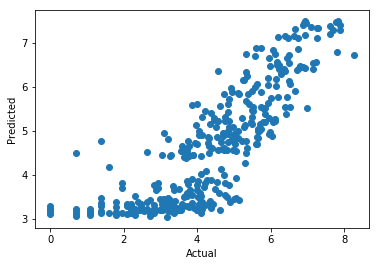

In [46]:
# Plot the comparison.
plt.scatter(y_ny14_ppr_orlt, predictions_ny14_ppr_orlt)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [47]:
# The NY 2013 model's score on the NY 2014 data. 
print('Score:', lm_tts_ny13.score(X_ny14_ppr_orlt, y_ny14_ppr_orlt))

Score: 0.668085601175


In [48]:
# Cross validate NY 2014 data with NY 2013 model.
scores_cv_ny14 = cross_val_score(lm_tts_ny13, X_ny14_ppr_orlt, y_ny14_ppr_orlt)

# The score for each fold.
print('Cross validated scores:', scores_cv_ny14)

# Mean score.
print('Average score:', scores_cv_ny14.mean())

Cross validated scores: [ 0.699  0.679  0.648]
Average score: 0.675283782445


##### b. Different State, Same Year

In [49]:
# Open the AL 2013 data.
df_al13 = pd.read_excel('table_8_offenses_known_to_law_enforcement_alabama_by_city_2013.xls', skiprows=4)
df_al13.dtypes

City                                       object
Population                                float64
Violent\ncrime                            float64
Murder and\nnonnegligent\nmanslaughter    float64
Rape\n(revised\ndefinition)1              float64
Rape\n(legacy\ndefinition)2               float64
Robbery                                   float64
Aggravated\nassault                       float64
Property\ncrime                           float64
Burglary                                  float64
Larceny-\ntheft                           float64
Motor\nvehicle\ntheft                     float64
Arson3                                    float64
Unnamed: 13                               float64
Unnamed: 14                               float64
Unnamed: 15                                object
dtype: object

In [50]:
# Rename applicable columns.
df_al13.rename(columns={'Population': 'population', 'Robbery': 'robbery', 'Property\ncrime': 'property_crime'}, inplace=True)
df_al13_ppr = df_al13[['population', 'robbery', 'property_crime']]

# Show null count.
df_al13_ppr.isnull().sum()

population        5
robbery           5
property_crime    5
dtype: int64

In [51]:
# Check the null rows.
df_al13_ppr[df_al13_ppr.isnull().any(axis=1)]

,population,robbery,property_crime
196,NaN,NaN,NaN
197,NaN,NaN,NaN
198,NaN,NaN,NaN
199,NaN,NaN,NaN
200,NaN,NaN,NaN


In [52]:
# Remove rows with nulls to prevent errors with log transformation.
df_al13_ppr = df_al13_ppr.dropna()

# Check for zeroes in property_crime.
df_al13_ppr[df_al13_ppr['property_crime'] == 0]

,population,robbery,property_crime
74,7820.0,0.0,0.0


In [53]:
# Remove rows with zeroes in property_crime to prevent errors with log transformation.
df_al13_ppr_nzpc = df_al13_ppr[df_al13_ppr['property_crime'] != 0]

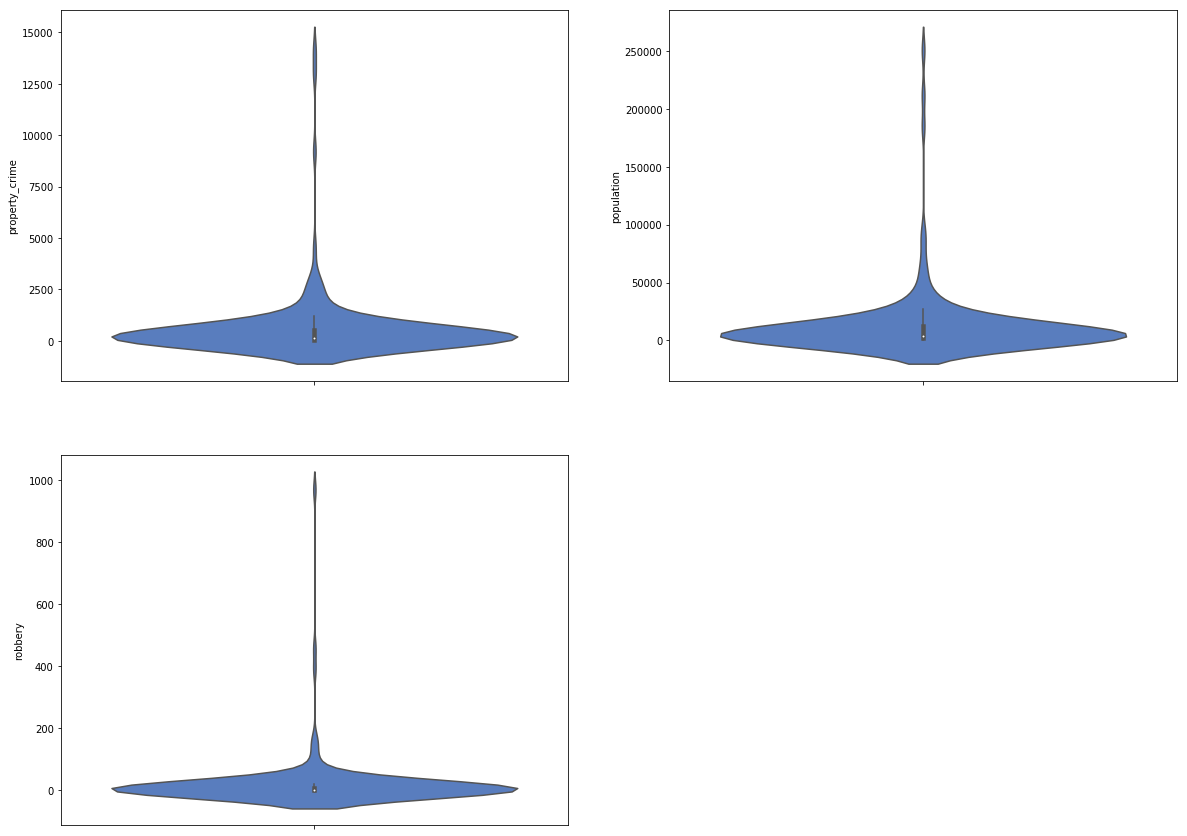

In [54]:
# Check for outliers.
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)

sns.violinplot(y='property_crime', palette='muted', data=df_al13_ppr_nzpc, ax=ax1)
sns.violinplot(y='population', palette='muted', data=df_al13_ppr_nzpc, ax=ax2)
sns.violinplot(y='robbery', palette='muted', data=df_al13_ppr_nzpc, ax=ax3)
plt.show()

In [55]:
# Show top outliers.
print(df_al13_ppr_nzpc['property_crime'].sort_values(ascending=False).head(10))
print('\n')
print(df_al13_ppr_nzpc['population'].sort_values(ascending=False).head(10))
print('\n')
print(df_al13_ppr_nzpc['robbery'].sort_values(ascending=False).head(10))

20     14157.0
117    13011.0
90      9216.0
182     4512.0
19      3199.0
68      2934.0
88      2596.0
47      2553.0
50      2502.0
141     2404.0
Name: property_crime, dtype: float64


117    250557.0
20     212001.0
90     184738.0
182     94126.0
88      84139.0
50      67811.0
16      57970.0
47      56091.0
110     45540.0
65      39481.0
Name: population, dtype: float64


20     969.0
117    459.0
90     391.0
182    161.0
19     161.0
148    134.0
68     104.0
7       78.0
50      78.0
60      67.0
Name: robbery, dtype: float64


In [56]:
# Remove outliers.
df_al13_ppr_or = df_al13_ppr_nzpc[df_al13_ppr_nzpc['population']<100000]

# Create the same features as NY 2013 and create the AL 2013 dataframe based on these features.
df_al13_ppr_or['population_squared'] = df_al13_ppr_or['population'] * df_al13_ppr_or['population']
df_al13_ppr_or['robbery_category'] = np.where(df_al13_ppr_or['robbery']>0, 1, 0)

# Set the variables.
y_al13_ppr_orlt = np.log(df_al13_ppr_or['property_crime'])
X_al13_ppr_orlt = df_al13_ppr_or[['population','population_squared', 'robbery_category']]

C:\Users\James\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\James\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [57]:
# Test the NY 2013 train/test split model on the AL 2013 data.
predictions_al13_ppr_orlt = regr_tts_ny13.predict(X_al13_ppr_orlt)

# Show the predicted vs. actual values.
print('Predicted:', predictions_al13_ppr_orlt[0:5])
print('\n')
print('Actual:')
print(y_al13_ppr_orlt[0:5])

Predicted: [ 4.457  4.63   3.094  6.569  5.498]


Actual:
0    4.143135
1    5.771441
2    3.218876
3    6.461468
4    6.493754
Name: property_crime, dtype: float64


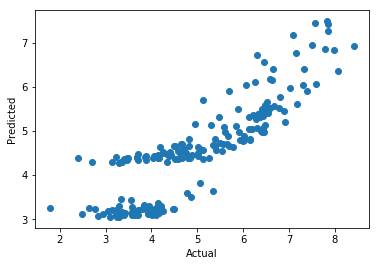

In [58]:
# Plot the comparison.
plt.scatter(y_al13_ppr_orlt, predictions_al13_ppr_orlt)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [59]:
# The NY 2013 model's score on AL 2013 data. 
print('Score:', lm_tts_ny13.score(X_al13_ppr_orlt, y_al13_ppr_orlt))

Score: 0.660421304149


In [60]:
# Cross validate AL 2013 data with NY 2013 model.
scores_cv_al13 = cross_val_score(lm_tts_ny13, X_al13_ppr_orlt, y_al13_ppr_orlt)

# The score for each fold.
print('Cross validated scores:', scores_cv_al13)

# Mean score.
print('Average score:', scores_cv_al13.mean())

Cross validated scores: [ 0.757  0.805  0.749]
Average score: 0.77054364969


A summary of the NY 2013 model test scores is shown below:

Method|NY 2013|NY 2014|AL 2013
------|-------|-------|-------
TTS   |  0.731|  0.668|  0.660
CV    |  0.707|  0.675|  0.771

All scores are roughly within the same range, which indicates the model is somewhat consistent in predicting property crime for different datasets. Also, cross validation generally improves the accuracy of the model.